Jeffrey Gordon, jtg2595

**This mini-project will be on Google colab. Make a copy for yourself and work on your own version. You do not need to download your code. Please do not submit your notebook, an HTML file, or anyother files. Click on Share bottom (on the top right), and change the permission to anyone with the link, give edit access, and then share the link on Canvas.**

*For all questions, include the Python commands/functions that you used to find your answer. Answers without supporting code will not receive credit. Visualization is, if no the most important, one of the most important part of any project, you visualizations will be graded as well.*

# Libraries 

Here I import some of the relevant libraries for your convinience, but feel free to make changes or import additional libraries, as needed. 

In [9]:
# Imports
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
import xgboost
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix

In [122]:
!pip install --upgrade git+https://github.com/afarahi/kllr.git
import kllr as kl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/afarahi/kllr.git to /tmp/pip-req-build-kfcbo431
  Running command git clone --filter=blob:none --quiet https://github.com/afarahi/kllr.git /tmp/pip-req-build-kfcbo431
  Resolved https://github.com/afarahi/kllr.git to commit 871d2afca647a8291554803850959e6f03933f15
  Preparing metadata (setup.py) ... done


# Calibration and Best Splitting Threshold (45 points)

In this mini-project, we want to explore the role of calibration and the best splitting threshold under a simple $\{0, 1\}$ cost function and a more complex utility function. Before that we go through data exploration, model selection, hyper-parametr tuning, and at the end we will get back to our main question of decision-making and the best splitting threshold.

First, let's load the dataset, `AHS_2019_Cleaned.csv`.

In [6]:
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/afarahi/Scientific-Machine-Learning/main/AHS_2019_Cleaned.CSV').drop('Unnamed: 0', axis=1) 
df.head()

,BLACK,HHSEX,METRO,HHGRAD,HHMAR,HHCITSHP,HHAGE,NUMPEOPLE,HINCP,DIVISION,OWNER
0,0.0,1,1.0,44,1,1,52,3,5.409933,5,1.0
1,0.0,2,1.0,44,4,1,80,2,5.303196,1,1.0
2,0.0,1,1.0,47,1,1,72,2,4.825426,7,1.0
3,1.0,2,1.0,40,6,1,60,1,4.544068,4,0.0
4,0.0,2,1.0,39,3,1,80,2,4.309630,4,0.0


### Understanding Data

We provide a definition of the variables provideded here. These definitions are taken from [2019 AHS definitions](https://www2.census.gov/programs-surveys/ahs/2019/2019\%20AHS\%20Definitions.pdf). If you are interested in learning more about each value please consult with the documentation. Here all the categorical variables are turned into a numeric variable, to see the associated value lables please download [this zip file](https://www2.census.gov/programs-surveys/ahs/2019/AHS%202019%20Value%20Labels%20Package.zip) and check out the `AHS 2019 Value Labels.csv`. This is important, you later need it! 

**Owner.** An owner is someone whose name is on the deed, mortgage, or contract to purchase. In some housing projects for the elderly, the residents can ``purchase'' a unit and pay monthly maintenance fees (including, for example, health, recreation, security, etc.). Such units are treated as owner-occupied. The ``purchaser'' cannot sell the unit, and upon death, ownership reverts to the sponsoring organization; no inheritance claim can occur.

**Household and count of households.** A household comprises all people who occupy a particular housing unit as their usual residence or who live there at the time of the interview and have no usual residence elsewhere. The usual residence is where the person lives and sleeps most of the time. This place is not necessarily the same as a legal, voting, or domicile residence. Households include not only occupants related to the householder but also any lodgers, roomers, boarders, partners, wards, foster children, and resident employees who share the living quarters of the householder. It includes people temporarily away for reasons such as visiting, traveling in connection with their jobs, attending school, in general hospitals, and in other temporary relocations. By definition, the count of households is the same as the count of occupied housing units.

**Black.** The classification of ‘‘race’’ refers to the race of the householder occupying the housing unit. The concept of race, as used by the Census Bureau, does not denote a clear-cut scientific definition of biological stock. Race is determined based on a question that asks for self-identification of a person's race. Respondents who refused to answer or do not know are entered as such
and imputed. Here we use a binary variable Black to indicade whether a household has anyone that self-identify as Black (`BLACK=1`) or not (`BLACK=0`).

**Income.** The survey covers total money income in the 12 months before the interview. It covers people age 16 and older (age 14 and older before 1999) currently living in the housing unit, even if they lived elsewhere during some of the previous 12 months. ``Money income'' is the income received on a regular basis (exclusive of certain money receipts such as capital gains and lump-sum payments) before payments for personal income taxes, social security, union dues, Medicare deductions, etc. It includes income received from wages, salary, commissions, bonuses, and tips; self-employment income from own nonfarm or farm businesses, including proprietorships and partnerships; interest, dividends, net rental income, royalty income, or income from estates and trusts; Social Security or Railroad Retirement income; Supplemental Security Income (SSI); any cash public assistance or welfare payments from the state or local welfare office; retirement, survivor, or disability benefits; and any other sources of income received regularly such as Veterans' (VA) payments, unemployment and/or worker's compensation, child support, and alimony. Respondents are asked to report income from the job at which the respondent worked the greatest number of weeks during the previous 12 months. A person's longest job is not necessarily the longest they have ever had. If the person had two or more jobs of equal length in the previous 12 months, the most recent job is considered the longest. The reported numbers are $log_{10}(income)$.

**Citizenship of householder.** Place of birth was asked for each householder and every household member. There are five categories of citizenship status: (1) born in the United States, (2) born in Puerto Rico or another U.S. outlying area, (3) born abroad of U.S. citizen parents, (4) naturalized citizens, or (5) noncitizens. People born in the United States are citizens at birth. Citizen by birth refers to categories 1-4 above.

**Division.** The U.S. is divided into four regions (Northeast, Midwest, South, and West) nine divisions. 

*Northeast.* The Northeast region is comprised of two
Census Divisions - New England and Middle Atlantic -
as well as the following states: Maine, New Hampshire, Vermont, Massachusetts, Rhode Island, Connecticut, New York, Pennsylvania, and New Jersey.

*Midwest.* The Midwest region is comprised of two Census Divisions–East North Central and West North Central–as well as the following states: Ohio, Indiana, Illinois, Michigan, Wisconsin, Minnesota, Iowa, Missouri, Kansas, Nebraska, North Dakota, and South Dakota.

*South.* The South region is comprised of three Census Divisions–South Atlantic, East South Central, and West South Central–as well as the following states: Delaware, Maryland, District of Columbia, Virginia, West Virginia, North Carolina, South Carolina, Georgia, Florida, Alabama, Mississippi, Tennessee, Kentucky, Arkansas, Louisiana, Oklahoma, and Texas.

*West.* The West region is comprised of two Census Divisions– Mountain and Pacific–as well as the following states: Montana, Wyoming, Colorado, New Mexico, Arizona, Utah, Idaho, Alaska, Washington, Oregon, Nevada, California, and Hawaii.

**Metropolitan/micropolitan area.** Metropolitan areas are composed of whole counties (towns in New England) that have significant levels of commuting and contiguous urban areas in common. They may cross state lines and usually include large amounts of rural land and farmland, provided the county or town as a whole qualifies. A metropolitan or micropolitan statistical area's geographic composition, or list of geographic components at a particular point in time, is referred to as its "delineation." Metropolitan and micropolitan statistical areas are delineated by the U.S. Office of Management and Budget (OMB) and are the result of the application of published standards to Census Bureau data.

### Data Exploration (6 points)

First, we want to explore this data set to see what we can learn from it. We again come back to this data set later in the course. 

Throught this assignment, the outcome variable is homeownership. We want to know whether we can predict who is a homeonwer and which householder is not using their household catacteristics. 


Income is the most important variable in guessing whether a householder is a homeowner as one might expect. Hence, let's use income as our independent variable in the following visualizations. 

Make three plots using the function `Plot_Fit_Summary_Split` in `KLLR` package. This function allows you to stratify your data on a third variable. For instance, `Plot_Fit_Summary_Split(df, 'X', 'Y', 'Z', split_bins=[0.0, 10, 20, 30], ...)` stratify `df`, a DataFrame object, on variable `Z` into three bins $Z \in [0, 10)$,  $Z \in [10, 20)$, and  $Z \in [20, 30)$ and then fit kllr to each subset. See the documentation for more details.


Now, use this function and 50 data bootstraps (set `nBootstrap = 50`). Just show the KLLR fits, do not visualize the raw data (set `show_data=False`). Also make sure to increase the number of bins, points at which the KLLR fit is computed. If you do not have enought data points then you do not get a smooth curve and lose interesting trends. Make the following visualizations:

(1) Stratify data on age (People < 30, People between 30 and 50, people between 50 and 60, and anyone above 60), and show the average homeownership as a function of income for each age group on the same plot. (1 point)

(2) Split the population into those with the head less than Bachelor's degree and those with at least a Bachelor's degree. Then plot the average homeownership as a function of householder's age for each education group on the same plot. (1 point)

(3) Stratify on variable 'BLACK' and plot the average homeownership as a function of income for race group on the same plot. (1 point)

(4) Then interpreted the trends in your data. (3 points)

I give you a more cmplex example, where data is stratified on both race and marital status. Please post on Ed Discussion if you do not understand something here. Make sure to make the x/y-labels informative so anyone who has no knowledge of this data set can understand what is plotted. Creating a good visualization takes time. Depends on your independent variable you might want to chose a different kernel width.  

100%|██████████| 34/34 [00:03<00:00, 11.11it/s]


(0.0, 1.0)

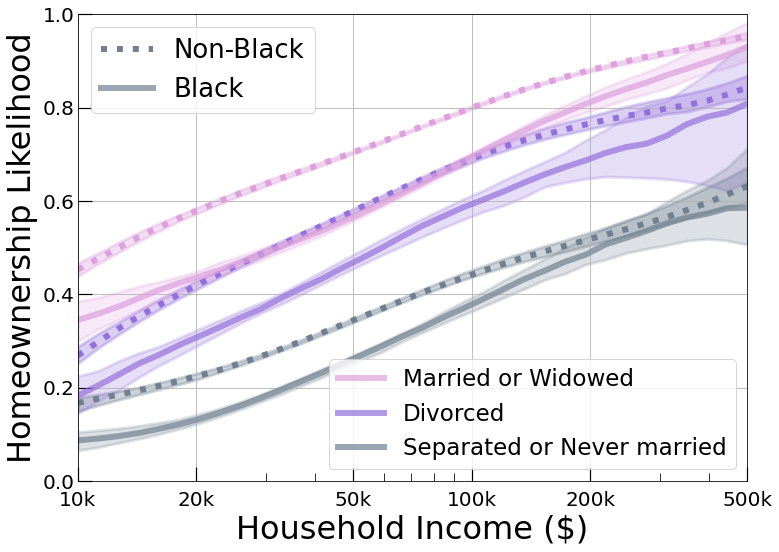

In [124]:
_, ax = kl.Plot_Fit_Summary_Split(df, 'HINCP', 'OWNER', 'HHMAR', split_bins=[0.5, 3.5, 4.5, 6.5],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7], 
                                  linestyle=':',  black_line=False,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25,
                                  show_data=False, xlog=True, ylog=False, color=['plum', 'mediumpurple', 'slategrey'],
                                  labels=['Household Income', 'Ownership Rate', 'X'], cmap = None, ax=None)

_, ax = kl.Plot_Fit_Summary_Split(df[::][df['BLACK']==1.0], 'HINCP', 'OWNER', 'HHMAR', split_bins=[0.5, 3.5, 4.5, 6.5],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7], 
                                  linestyle='-',  black_line=False, alpha=0.7,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25, fast_calc = False,
                                  show_data=False, xlog=True, ylog=False, color=['plum', 'mediumpurple', 'slategrey'], labels=['Household Income', 'Ownership Rate', 'X'], ax=ax)


ax.flat[1].set_visible(False)
ax.flat[2].set_visible(False)

ax[0].lines[0].set_label(None)
ax[0].lines[1].set_label(None)
ax[0].lines[2].set_label(None)
ax[0].lines[3].set_label(r'Married or Widowed')
ax[0].lines[4].set_label(r'Divorced')
ax[0].lines[5].set_label(r'Separated or Never married')

for line in ax[0].get_lines()[:]: line.set_linewidth(6)

legend1 = ax[0].legend([ax[0].lines[2], ax[0].lines[5]], ["Non-Black", "Black"], prop={'size':26}, loc=2)
ax[0].add_artist(legend1)
ax[0].legend(loc=4, prop={'size':23})

ax[0].set_ylabel('Homeownership Likelihood', size=32)
ax[0].set_xlabel('Household Income ($)', size=32)
ax[0].tick_params(labelbottom=True)
ax[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])
ax[0].set_xlim(1e4, 5e5)
ax[0].set_ylim(0.0, 1.0)

100%|██████████| 34/34 [00:05<00:00,  5.67it/s]


[Text(10000.0, 0, '10k'),
 Text(20000.0, 0, '20k'),
 Text(50000.0, 0, '50k'),
 Text(100000.0, 0, '100k'),
 Text(200000.0, 0, '200k'),
 Text(500000.0, 0, '500k')]

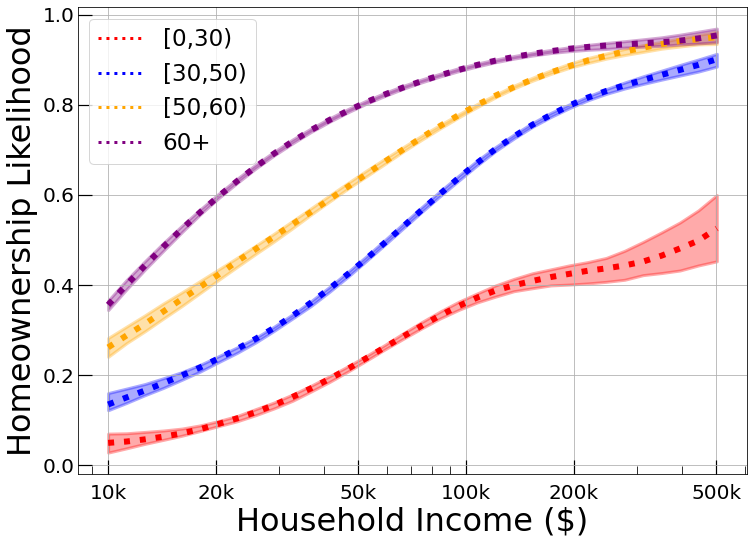

In [125]:
# Ownership on Income, Binned By Age
_, ax_age = kl.Plot_Fit_Summary_Split(df, 'HINCP', 'OWNER', 'HHAGE', split_bins=[0.0, 30.0, 50.0, 60.0, 200.0],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7], 
                                  linestyle=':',  black_line=False,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25,
                                  show_data=False, xlog=True, ylog=False, color=['red', 'blue', 'orange', 'purple', 'yellow'],
                                  labels=['Household Income', 'Ownership Rate', 'X'], cmap = None, ax=None)

ax_age.flat[1].set_visible(False)
ax_age.flat[2].set_visible(False)

# Set legend labels
ax_age[0].lines[0].set_label(r'[0,30)')
ax_age[0].lines[1].set_label(r'[30,50)')
ax_age[0].lines[2].set_label(r'[50,60)')
ax_age[0].lines[3].set_label(r'60+')
ax_age[0].legend(prop={'size':23})

for line in ax_age[0].get_lines()[:]: line.set_linewidth(6)

# Axis labels
ax_age[0].set_ylabel('Homeownership Likelihood', size=32)
ax_age[0].set_xlabel('Household Income ($)', size=32)

# Intervals
ax_age[0].tick_params(labelbottom=True)
ax_age[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax_age[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])

From the regression lines, it seems that age does have a general correlation with likelihood of home ownership. The older the age group, the more likely home ownership overall. Then as the income rises, the likelihood increases as well.

100%|██████████| 34/34 [00:03<00:00, 10.52it/s]


[Text(10000.0, 0, '10k'),
 Text(20000.0, 0, '20k'),
 Text(50000.0, 0, '50k'),
 Text(100000.0, 0, '100k'),
 Text(200000.0, 0, '200k'),
 Text(500000.0, 0, '500k')]

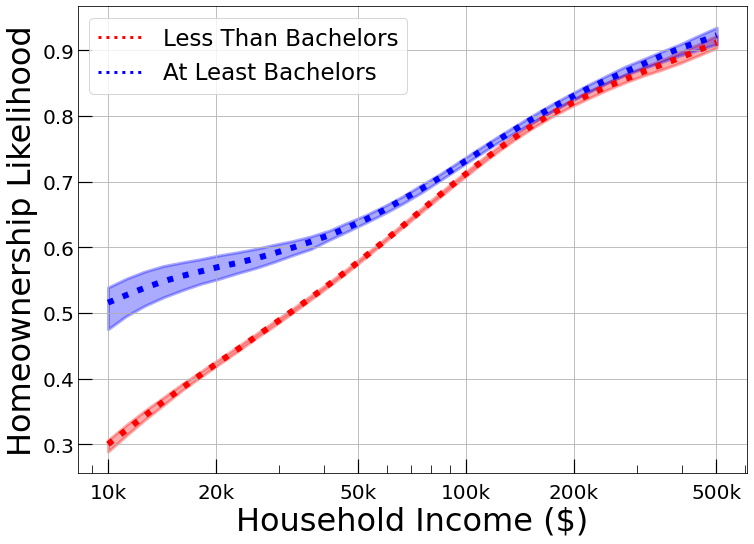

In [126]:
# Ownership on Income, Binned by bachelors
_, ax_deg = kl.Plot_Fit_Summary_Split(df, 'HINCP', 'OWNER', 'HHGRAD', split_bins=[0.0, 44.0, 50.0],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7], 
                                  linestyle=':',  black_line=False,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25,
                                  show_data=False, xlog=True, ylog=False, color=['red', 'blue', 'orange', 'purple', 'yellow'],
                                  labels=['Household Income', 'Ownership Rate', 'X'], cmap = None, ax=None)

ax_deg.flat[1].set_visible(False)
ax_deg.flat[2].set_visible(False)

# Set legend labels
ax_deg[0].lines[0].set_label(r'Less Than Bachelors')
ax_deg[0].lines[1].set_label(r'At Least Bachelors')
ax_deg[0].legend(prop={'size':23})

for line in ax_deg[0].get_lines()[:]: line.set_linewidth(6)

# Axis labels
ax_deg[0].set_ylabel('Homeownership Likelihood', size=32)
ax_deg[0].set_xlabel('Household Income ($)', size=32)

# Intervals
ax_deg[0].tick_params(labelbottom=True)
ax_deg[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax_deg[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])

From the regression, it seems that the degree held does matter as well (for lower income households). When the income reaches around 100k, degree doesnt matter in terms of house ownership likelihood.

100%|██████████| 34/34 [00:03<00:00,  9.68it/s]


[Text(10000.0, 0, '10k'),
 Text(20000.0, 0, '20k'),
 Text(50000.0, 0, '50k'),
 Text(100000.0, 0, '100k'),
 Text(200000.0, 0, '200k'),
 Text(500000.0, 0, '500k')]

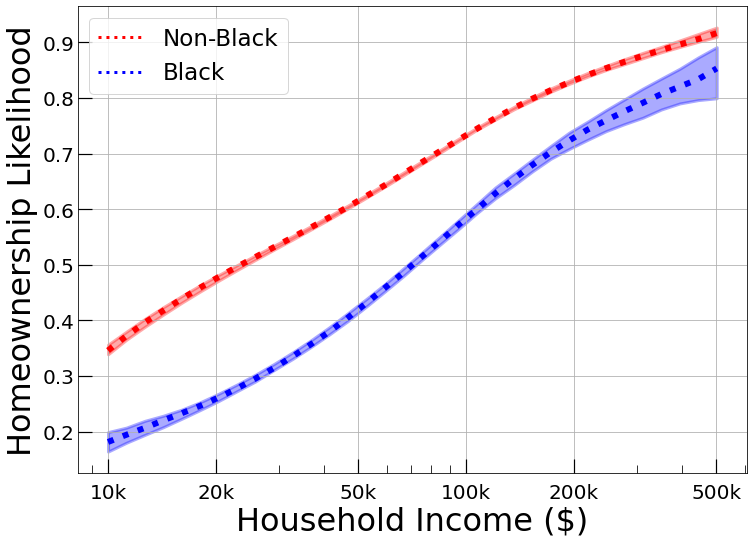

In [127]:
# Ownership on income, binned by black
_, ax_blk = kl.Plot_Fit_Summary_Split(df, 'HINCP', 'OWNER', 'BLACK', split_bins=[-.1, 0.1, 2],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7], 
                                  linestyle=':',  black_line=False,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25,
                                  show_data=False, xlog=True, ylog=False, color=['red', 'blue', 'orange', 'purple', 'yellow'],
                                  labels=['Household Income', 'Ownership Rate', 'X'], cmap = None, ax=None)

ax_blk.flat[1].set_visible(False)
ax_blk.flat[2].set_visible(False)
ax_blk[0].lines[0].set_label(r'Non-Black')
ax_blk[0].lines[1].set_label(r'Black')
ax_blk[0].legend(prop={'size':23})
for line in ax_blk[0].get_lines()[:]: line.set_linewidth(6)
ax_blk[0].set_ylabel('Homeownership Likelihood', size=32)
ax_blk[0].set_xlabel('Household Income ($)', size=32)
ax_blk[0].tick_params(labelbottom=True)
ax_blk[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax_blk[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])

From the graph, race does matter in likelihood of household ownership. The black group seems to have less likelihood overall, but the trend is still as income rises, so does likelihood of house ownership.

### Model selection and hyper-parameter tuning (8 points)

To select the best model and its hyper-parameters, we will split the sample into a 66% training set and a 33% validation set. We will only train two models, a Random Forest Regressor and a XGBoost Regressor, using the libraries that have been loaded.

Our first goal is to find the `max_depth` value that maximizes the AUC score. We will not change the other hyper-parameters and will use their default values.

We want to obtain not only a point estimation for the AUC score but also quantify the uncertainty of the AUC score. To achieve this, we will run 10 random train/test (66/33%) splits for each model and each `max_depth` value (**do not** bootstrap or perform $k$-fold cross validation). We will then plot the mean and standard deviation of the AUC score as a function of `max_depth` for each model. 

After that, we will determine the superior model and use it as our reference model.

In [11]:
features = ['BLACK', 'HHSEX', 'METRO', 'HHGRAD', 'HHMAR', 'HHCITSHP', 'HHAGE', 'NUMPEOPLE', 'HINCP', 'DIVISION']
dependent_var = ['OWNER']

X = df[features]
y = df[dependent_var]

# 66/33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 1)

max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [12]:
# Max Depth/AUC for Random Forest
best_max_depth = None
best_auc_score = 0

# Calculate AUC for each max depth
for d in max_depth_array:
  model = RandomForestRegressor(max_depth = d)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  auc = roc_auc_score(y_test, y_pred)
  if auc > best_auc_score:
    best_max_depth = d
    best_auc_score = auc

print(f"The best max depth value is {best_max_depth} with a score of {best_auc_score}")

The best max depth value is 10 with a score of 0.8205464671323964


In [13]:
# Max Depth/AUC for XGBoost
best_max_depth = None
best_auc_score = 0

# Calculate AUC for each max depth
for d in max_depth_array:
  model = XGBClassifier(max_depth = d)
  model.fit(X_train, y_train)
  Y_pred_proba = model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, Y_pred_proba)
  if auc > best_auc_score:
    best_max_depth = d
    best_auc_score = auc

print(f"The best max depth value is {best_max_depth} with a score of {best_auc_score}")

The best max depth value is 3 with a score of 0.8262014534308131


From the AUC score, XGBoost performs better by a minimal amount. Rounding to the third decimal place, Random Forest is .824 and XGB is .826. So essentially the same.

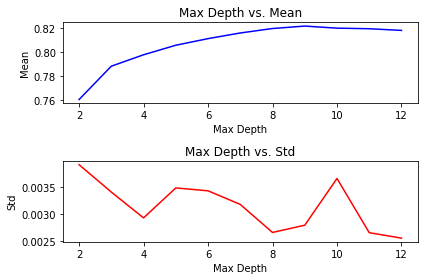

In [14]:
# Random Forest Uncertainty

# Max Depth x Iteration = AUC
auc_matrix = np.zeros((len(max_depth_array), 10))

for d in max_depth_array:
  for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = d**2+i**2)
    rf = RandomForestRegressor(max_depth = d).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    auc_matrix[d-2, i] = auc

# Mean, Std Dev of AUC per max depth
mean_auc = np.mean(auc_matrix, axis=1)
std_auc = np.std(auc_matrix, axis = 1)

figure, axis = plt.subplots(2, 1)

# Mean
axis[0].plot(max_depth_array, mean_auc, color = 'blue')
axis[0].set_title("Max Depth vs. Mean")
axis[0].set_xlabel("Max Depth")
axis[0].set_ylabel("Mean")

# Std
axis[1].plot(max_depth_array, std_auc, color = 'red')
axis[1].set_title("Max Depth vs. Std")
axis[1].set_xlabel("Max Depth")
axis[1].set_ylabel("Std")
figure.tight_layout()
plt.show()

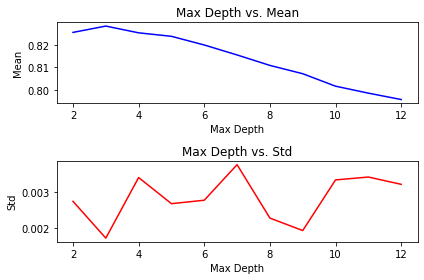

In [15]:
# XGB Uncertainty

auc_matrix = np.zeros((len(max_depth_array), 10))

for d in max_depth_array:
  for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = d**2+i**2)
    rf = XGBClassifier(max_depth = d).fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_matrix[d-2, i] = auc

mean_auc = np.mean(auc_matrix, axis=1)
std_auc = np.std(auc_matrix, axis = 1)

figure, axis = plt.subplots(2, 1)

axis[0].plot(max_depth_array, mean_auc, color = 'blue')
axis[0].set_title("Max Depth vs. Mean")
axis[0].set_xlabel("Max Depth")
axis[0].set_ylabel("Mean")

axis[1].plot(max_depth_array, std_auc, color = 'red')
axis[1].set_title("Max Depth vs. Std")
axis[1].set_xlabel("Max Depth")
axis[1].set_ylabel("Std")
figure.tight_layout()
plt.show()

### Evaluation (13 points)

From here, we will define three models. The first model is a `RandomForestRegressor` with `max_depth=3`. This will be our base model. The second model, is the best model determined from the above excercise. The last model will be a calibrated `RandomForestClassifier` with `max_depth=10`. Use `method='isotonic'` for calibration. (3 points)

Then plot two ROC curve for each classifier, one for the test and one for the training sample, and report the AUC for the test sample on the plot with 2 significant digits. (4 points)

Using this result, describe which model is better and why. (2 points)

In [16]:
# Train/Test Splits, Models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)
clf_base = RandomForestRegressor(max_depth=3).fit(X_train, y_train)
clf_best = XGBClassifier(max_depth = 3).fit(X_train, y_train)
clf_cali = CalibratedClassifierCV(RandomForestClassifier(max_depth = 10), method = 'isotonic').fit(X_train, y_train)

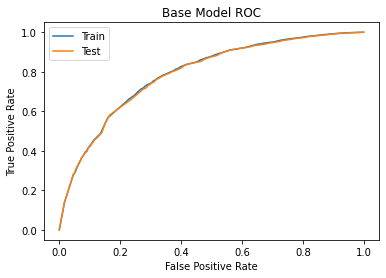

Test AUC is: 0.79


In [19]:
# Base Model ROC

# Predictions
y_pred_train = clf_base.predict(X_train)
y_pred_test = clf_base.predict(X_test)

# FPR / TPR
fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  y_pred_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test,  y_pred_test)

# Plotting
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Base Model ROC')
plt.show()

print(f"Test AUC is: {round(roc_auc_score(y_test, y_pred_test),2)}")

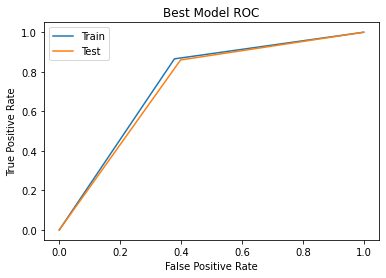

Test AUC is: 0.73


In [20]:
# Best Model ROC

# Predictions
y_pred_train = clf_best.predict(X_train)
y_pred_test = clf_best.predict(X_test)

# FPR / TPR
fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  y_pred_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test,  y_pred_test)

# Plotting
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Best Model ROC')
plt.show()

print(f"Test AUC is: {round(roc_auc_score(y_test, y_pred_test),2)}")

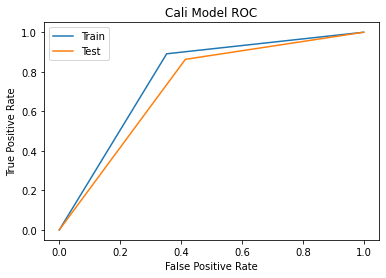

Test AUC is: 0.72


In [21]:
# Calibrated Model ROC

# Predictions
y_pred_train = clf_cali.predict(X_train)
y_pred_test = clf_cali.predict(X_test)

# FPR / TPR
fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  y_pred_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test,  y_pred_test)

# Plotting
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Cali Model ROC')
plt.show()

print(f"Test AUC is: {round(roc_auc_score(y_test, y_pred_test),2)}")

Based on the AUC, the base model performed the best. This is also shown in the ROC curve, as the area under the ROC curve is the largest in the base model. A higher AUC means that the model classifies class 0 samples more correctly AND class 1 samples more correctly. So it is balanced on both ends, which is an overall better model. When you see a higher AUC, even with a low FPR, there is still a high TPR.

Now, create two calibration curves for each classifier, one for the test and one for the training sample. (2 points)

Then, interprete the plot and discuss which model is calibrated and which model is miscalibrated. (2 points)

Note that to make a calibdarion curve the model's prediction must be a number between 0 and 1. `RandomForestRegressor` and `XGBRegressor` are regression model and their prediction is not gauranteed to be between this range. Use the followin formulat to renarmalize their prediction:

$$
p(x) = \frac{f(x) - \min(f(.))}{\max(f(.)) - \min(f(.))}
$$


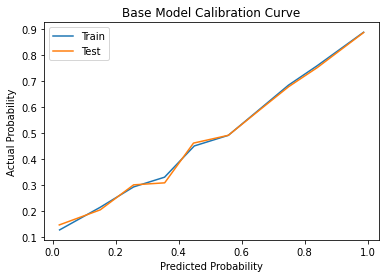

In [22]:
# Base Calibration Curve

# Getting Probabilities 
y_prob_train = clf_base.predict(X_train)
y_prob_train = (y_prob_train - min(y_prob_train)) / (max(y_prob_train) - min(y_prob_train))
true_prob_train, pred_prob_train = calibration_curve(y_train, y_prob_train, n_bins=10)

y_prob_test = clf_base.predict(X_test)
y_prob_test = (y_prob_test - min(y_prob_test)) / (max(y_prob_test) - min(y_prob_test))
true_prob_test, pred_prob_test = calibration_curve(y_test, y_prob_test, n_bins=10)

plt.plot(pred_prob_train, true_prob_train, label = 'Train')
plt.plot(pred_prob_test, true_prob_test, label = 'Test')
plt.legend()
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.title('Base Model Calibration Curve')

plt.show()

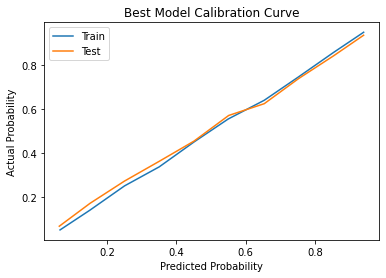

In [23]:
# Best Calibration Curve

# Getting Probabilities 
y_prob_train = clf_best.predict_proba(X_train)[:,1]
y_prob_train = (y_prob_train - min(y_prob_train)) / (max(y_prob_train) - min(y_prob_train))
true_prob_train, pred_prob_train = calibration_curve(y_train, y_prob_train, n_bins=10)

y_prob_test = clf_best.predict_proba(X_test)[:,1]
y_prob_test = (y_prob_test - min(y_prob_test)) / (max(y_prob_test) - min(y_prob_test))
true_prob_test, pred_prob_test = calibration_curve(y_test, y_prob_test, n_bins=10)

plt.plot(pred_prob_train, true_prob_train, label = 'Train')
plt.plot(pred_prob_test, true_prob_test, label = 'Test')
plt.legend()
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.title('Best Model Calibration Curve')

plt.show()

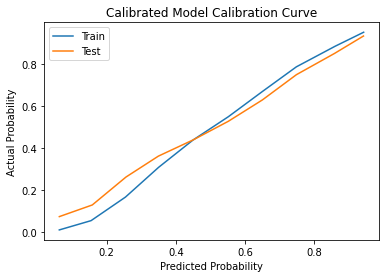

In [24]:
# Calibrated Calibration Curve

# Getting Probabilities 
y_prob_train = clf_cali.predict_proba(X_train)[:,1]
y_prob_train = (y_prob_train - min(y_prob_train)) / (max(y_prob_train) - min(y_prob_train))
true_prob_train, pred_prob_train = calibration_curve(y_train, y_prob_train, n_bins=10)

y_prob_test = clf_cali.predict_proba(X_test)[:,1]
y_prob_test = (y_prob_test - min(y_prob_test)) / (max(y_prob_test) - min(y_prob_test))
true_prob_test, pred_prob_test = calibration_curve(y_test, y_prob_test, n_bins=10)

plt.plot(pred_prob_train, true_prob_train, label = 'Train')
plt.plot(pred_prob_test, true_prob_test, label = 'Test')
plt.legend()
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.title('Calibrated Model Calibration Curve')

plt.show()

The closer the curve is to a straight line (identity function), the more calibrated it is. That means the ratio to predicted = ratio to actual. The worst calibrated model is the base model, and the most calibrated is the best model, which even beat the calibrated model.

### Best Classification Threshold (5 points)

Our next aim is to check one of the main claims made in [this paper](https://link.springer.com/chapter/10.1007/978-3-540-30116-5_14). Specifically, they show the optimal decision rule, that is, the optimal function that maps a sample $x$ to one of the values of $C \in \{0, 1\}$, under the 0-1 cost function, is the maximum a- posteriori (MAP) rule
$$
  g(x) = \arg \max_{C \in \{0, 1\}} f(x)
$$
where $f(x)$ is the probabilistic classifier. This implies the optimal dcision threshold is at $f(x) = 0.5$ for a calibrated classifier. Under this decision rule the error rate minimizes,
$$
 {\rm Err} = 1 - {\rm Accuracy} = \frac{FN + FP}{P + N}.
$$

To show this, make a plot that computes the error rate as a function of decision threshold for each classifier for the test sample. (3 points)

Now, interpret the result. (2 points) 

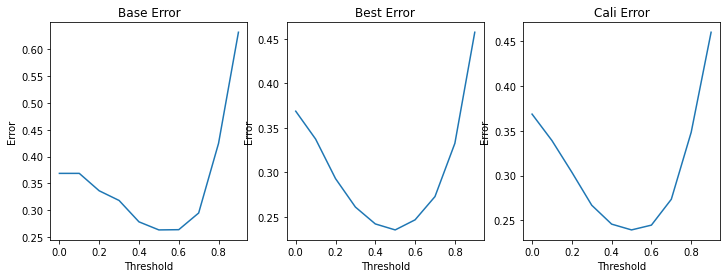

In [31]:
# Error = f(Threshold)

# Define Error Function
def err(false_neg, false_pos, pos, neg):
  return (false_neg + false_pos) / (pos + neg)

# Define thresholds
th = np.arange(0,1,.1)

# Model x Threshold = Error
errors = np.zeros((3, len(th)))

# Iterate through th and get predicted values per th
for i, threshold in enumerate(th):
  # Get predicted values
  base_y = clf_base.predict(X_test)
  best_y = clf_best.predict_proba(X_test)[:,1]
  cali_y = clf_cali.predict_proba(X_test)[:,1]

  # Classify based on threshold
  base_y = np.where(base_y >= threshold, 1, 0)
  best_y = np.where(best_y >= threshold, 1, 0)
  cali_y = np.where(cali_y >= threshold, 1, 0)

  # Get actual classes and create confusion matrix for each model
  base_conf = confusion_matrix(y_test, base_y)
  best_conf = confusion_matrix(y_test, best_y)
  cali_conf = confusion_matrix(y_test, cali_y)

  # Calculate Error for each model
  TN, FP, FN, TP = base_conf.ravel()
  P = FN + TP
  N = TN + FP
  errors[0, i] = err(FN, FP, P, N)

  TN, FP, FN, TP = best_conf.ravel()
  P = FN + TP
  N = TN + FP
  errors[1, i] = err(FN, FP, P, N)

  TN, FP, FN, TP = cali_conf.ravel()
  P = FN + TP
  N = TN + FP
  errors[2, i] = err(FN, FP, P, N)

# Plotting
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axs[0].plot(th, errors[0,:])
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Error')
axs[0].set_title('Base Error')

axs[1].plot(th, errors[1,:])
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Error')
axs[1].set_title('Best Error')

axs[2].plot(th, errors[2,:])
axs[2].set_xlabel('Threshold')
axs[2].set_ylabel('Error')
axs[2].set_title('Cali Error')

plt.show()

The results of the graph are persistent with the paper. The lowest error for all three models is at .5. This is the optimal decision rule.

### Decision Making Under Non-trivial Cost Function (8 points)


Now, suppose a non-trivial cost function that changes with the age of the housholder. Let's assume that the reward of TP = TN = 1, and the costs of the FP and FN are as following:


$$ C({\rm FP}) = (1 - {\rm Age} / 100) \times 2 $$

$$ C({\rm FN}) = (1 - {\rm Age} / 100) \times 0.5 $$

Write a function that computes the utility for a given decision threshold of ${\rm th}$. You want to use this equation to estimate the utility function. 

$\hat{U} = \frac{1}{n_{\rm test}}\sum_{i=1}^{n_{\rm test}}\left[\mathbb{I}(y_i - \hat{f}_i) \times R(x_i, y_i) - |y_i - \hat{f}_i| \times C(x_i, y_i) \right]$

Finally, compute and reprot the utility of the test sample assuming ${\rm th} = 0.5$ for all three classifiers using the test sample. The code is given to you. You just need to complete the utility function computation. (3 points) 


In [51]:
def cost(pred, true, age):
  if pred == true:
    return 0
  elif pred > true:
    return (1 - age/100) * 2
  else:
    return (1 - age/100) * .5

def reward(pred, true):
  if pred == true:
    return 1
  else:
    return 0

def utility(p, y_true, age, th):
  p = np.where(p >= th, 1, 0)
  utility = 0
  for pred, true, age in zip(p, y_true, age):
    utility += (reward(pred, true) - cost(pred, true, age))

  utility /= len(p)

  return utility

In [53]:
y_true = y_test.OWNER.to_numpy()
age = X_test.HHAGE.to_numpy()

# Probabilities
p_base = clf_base.predict(X_test)
p_best = clf_best.predict_proba(X_test)[:,1] 
p_cali = clf_cali.predict_proba(X_test)[:,1]

base_util = round(utility(p_base, y_true, age, .5), 2)
best_util = round(utility(p_best, y_true, age, .5), 2)
cali_util = round(utility(p_cali, y_true, age, .5), 2)

print(f"Base Classifier Utility (th = 0.5) = {base_util}")
print(f"Best Classifier Utility (th = 0.5) = {best_util}")
print(f"Calibrated Classifier Utility (th = 0.5) = {cali_util}")

Base Classifier Utility (th = 0.5) = 0.54
Best Classifier Utility (th = 0.5) = 0.61
Calibrated Classifier Utility (th = 0.5) = 0.6


Now, make a plot that shows the utility of the three model as a function of ${\rm th} \in [0, 1]$. (2 points)

Which classifier is preffered? (1 point)

Approximately, where is the best decision threshold for each classifier? (1 point)

Why do you think we see this shift w.r.t. the 0-1 cost function's best decision threshold? (1 point)

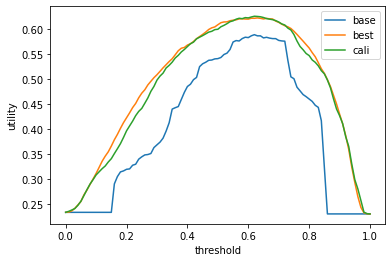

In [55]:
base_util = [utility(p_base, y_true, age, th/100) for th in range(101)]
best_util = [utility(p_best, y_true, age, th/100) for th in range(101)]
cali_util = [utility(p_cali, y_true, age, th/100) for th in range(101)]
x_axis = np.arange(0,1.01,.01)

plt.plot(x_axis, base_util, label = 'base')
plt.plot(x_axis, best_util, label = 'best')
plt.plot(x_axis, cali_util, label = 'cali')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('utility')
plt.show()

Now, the highest utility seems to be at a threshold of .6, instead of .5. This means that the model must be more conservative in assigning 1's in order to guess more correctly. Which is saying that the model has to be even more certain than usual to classify a home owner, in order to be the most accurate.

### Decision Fairness (5 points)

While the above threshold might be optimal for the whole population, this does not imply that this is the optimal deiciosn threshold for each sub-population. Let's test this.

Stratify the data into Black and non-Black households. For each set of houeholds make a similar plot as above (two panel plot, one for Black and one for non-Black households). (2 points)

 What is the best decision threshold that maximizes the utility of each subpopulation? Is this fair to use the same threshold for the entire population? Justify your answer. (3 points) 

In [56]:
race = X_test.BLACK.to_numpy()
black_msk = race == 1
nonblack_msk = ~black_msk

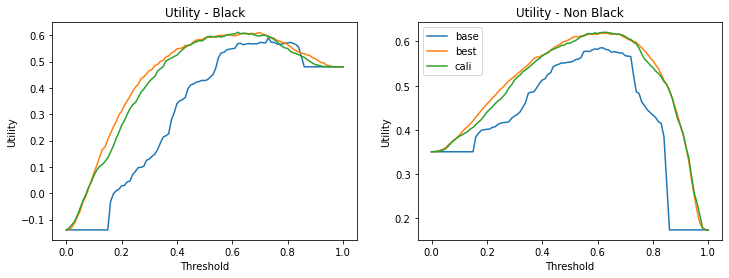

In [57]:
# Black Households
p_base_black = np.array([pred for pred, m in zip(p_base, black_msk) if m])
p_best_black = np.array([pred for pred, m in zip(p_best, black_msk) if m])
p_cali_black = np.array([pred for pred, m in zip(p_cali, black_msk) if m])
y_true_black = np.array([t for t, m in zip(y_true, black_msk) if m])

# Non Black Households
p_base_n = np.array([pred for pred, m in zip(p_base, nonblack_msk) if m])
p_best_n = np.array([pred for pred, m in zip(p_best, nonblack_msk) if m])
p_cali_n = np.array([pred for pred, m in zip(p_cali, nonblack_msk) if m])
y_true_n = np.array([t for t, m in zip(y_true, nonblack_msk) if m])

# Black Utility
base_util_th_black = [utility(p_base_black, y_true_black, age, th/100) for th in range(101)]
best_util_th_black = [utility(p_best_black, y_true_black, age, th/100) for th in range(101)]
cali_util_th_black = [utility(p_cali_black, y_true_black, age, th/100) for th in range(101)]

# Non Black Utility
base_util_th_n = [utility(p_base_n, y_true_n, age, th/100) for th in range(101)]
best_util_th_n = [utility(p_best_n, y_true_n, age, th/100) for th in range(101)]
cali_util_th_n = [utility(p_cali_n, y_true_n, age, th/100) for th in range(101)]

# Plotting
x_ = np.arange(0,1.01,.01)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axs[0].plot(x_, base_util_th_black, label = 'base')
axs[0].plot(x_, best_util_th_black, label = 'best')
axs[0].plot(x_, cali_util_th_black, label = 'cali')
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Utility')
axs[0].set_title('Utility - Black')

axs[1].plot(x_, base_util_th_n, label = 'base')
axs[1].plot(x_, best_util_th_n, label = 'best')
axs[1].plot(x_, cali_util_th_n, label = 'cali')
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Utility')
axs[1].set_title('Utility - Non Black')

plt.legend()
plt.show()

The Non Black utility curve relatively stayed the same, with the optimal threshold being .6. The optimal threshold is still .6 for the black, but it seems to handle higher thresholds better. This intuitively means that Non Black is a strong predictor, so the model needs to be more conservative in choosing. But, Black is not a strong predictor, so it can afford to be less conservative.

***Final note. Ideally we want to get a confidence interval before conclusing which model/decision threshold is preffered and not rely on one train/test split. But since it is computationally expensive, for this assignment we only rely on one train/test split realization.***

Any feedback on this assignment or previous ones are appreciated. You do not need to, but if you are willing to share your feedback please use the following text box. 

*your feedback*

# THE END